# Example Notebook to load data

### Library imports

In [52]:
import sys # os stands for "operating system" and includes read/write routines etc. 
import mkl
from src import utils # this is our own library of functions
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import pandas as pd 
sns.set_context("talk")
mkl.set_num_threads(10)
sys.path.insert(0,r'C:\Users\WinDesktopMP\Documents\suite2p')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [351]:
exp_db = []
exp_db = utils.add_exp(exp_db, 'DR10', '2022_07_11', '1')
exp_db = utils.add_exp(exp_db, 'TX80', '2022_06_17', '1')
timeline_block = [1,1]
frames_per_folder = [0,0]

In [352]:
Sessions = utils.build_sessions(exp_db, frames_per_folder, timeline_block, dual_plane=True, baseline=True)

Session: 0
planes: 20


100%|██████████| 20/20 [06:25<00:00, 19.27s/it]


total neurons: 56096
Session: 1
planes: 20


100%|██████████| 20/20 [06:27<00:00, 19.38s/it]


total neurons: 59181


In [353]:
summ_id = []
summ_date = []
summ_block = []
summ_layer = []
summ_traintex = []
summ_acc = []
summ_margin = []
summ_catpair = []
summ_sess = []
n_categories = 8 
n_samples = 4
n_pairs = 28 
layers = [1,2]

Todo: add the possibility to work with reps not only with avg_reps = true

In [354]:
for sess in range(len(exp_db)):
    acurracy_per_layer = []
    spop_per_layer = []
    margin_per_layer = []
    mean_margin_L1 = []
    mean_margin_L2 = []
    Sessions[sess].cats, Sessions[sess].stim_idx, Sessions[sess].nreps = utils.get_stim_class_and_samples_ix(Sessions[sess].subset_stim, n_categories=8, samples_per_cat=4)
    for layer in layers:
        accuracy, pairs, spops, cat_dict = utils.PairwiseDprimeDecoder(Sessions[sess].neurons_atframes, Sessions[sess].stim_idx, Sessions[sess].iplane, Sessions[sess].cats,
                                                                        n_categories = n_categories, n_samples = n_samples, layer = layer , avg_reps = True)
        gen_marg = utils.get_generalization_margings(spops, n_pairs = n_pairs, n_textures = n_samples)
        acurracy_per_layer.append(accuracy)
        spop_per_layer.append(spops)
        margin_per_layer.append(gen_marg)

    for pair in range(n_pairs):
        mean_margin_L1.append(utils.get_margin_per_category(margin_per_layer[0],pair,avg=True))
        mean_margin_L2.append(utils.get_margin_per_category(margin_per_layer[1],pair,avg=True))

    Sessions[sess].acurracy_per_layer = np.array(acurracy_per_layer)
    Sessions[sess].spop_per_layer = np.array(spop_per_layer)
    Sessions[sess].margin_per_layer = np.array(margin_per_layer)
    Sessions[sess].mean_margin_L1 = np.array(mean_margin_L1)
    Sessions[sess].mean_margin_L2 = np.array(mean_margin_L2)
    Sessions[sess].cat_pairs = utils.categorypairs_parser(cat_dict,pairs)

    # create a summary 
    summ_id.append([Sessions[sess].name]*n_pairs*n_samples*len(layers))
    summ_date.append([Sessions[sess].date] * n_pairs*n_samples*len(layers))
    summ_block.append([Sessions[sess].block] * n_pairs*n_samples*len(layers))
    summ_sess.append(np.repeat(sess, n_pairs*n_samples*len(layers)))
    summ_layer.append(np.append(np.repeat(1,n_samples*n_pairs),np.repeat(2,n_samples*n_pairs)))
    summ_traintex.append(np.tile(np.tile(np.arange(n_samples),n_pairs),len(layers)))
    summ_acc.append(Sessions[sess].acurracy_per_layer.reshape((n_pairs*n_samples)*len(layers),-1).flatten())
    summ_margin.append(np.append(Sessions[sess].mean_margin_L1.reshape(n_pairs*n_samples,-1).flatten(),Sessions[sess].mean_margin_L2.reshape(n_pairs*n_samples,-1).flatten()))
    summ_catpair.append(np.tile(np.repeat(np.array(Sessions[sess].cat_pairs),n_samples),len(layers)))

summary_sessions = pd.DataFrame({
"Session": np.concatenate(np.array(summ_sess, dtype=object),axis=0),
"ID": np.concatenate(np.array(summ_id, dtype=object),axis=0),
"Date": np.concatenate(np.array(summ_date, dtype=object),axis=0),
"Block": np.concatenate(np.array(summ_block, dtype=object),axis=0),
"Layer": np.concatenate(np.array(summ_layer, dtype=object),axis=0),
"Training_tex" : np.concatenate(np.array(summ_traintex, dtype=object),axis=0),
"Accuracy": np.concatenate(np.array(summ_acc, dtype=object),axis=0),
"Margin": np.concatenate(np.array(summ_margin, dtype=object),axis=0),
"Category_Pair": np.concatenate(np.array(summ_catpair, dtype=object),axis=0)
})

summary_sessions.head()

8 categories, 32 exemplars, 25 repeats
8 categories, 32 exemplars, 98 repeats


,Session,ID,Date,Block,Layer,Training_tex,Accuracy,Margin,Category_Pair
0,0,DR10,2022_07_11,1,1,0,100.0,0.137255,leaves/circles
1,0,DR10,2022_07_11,1,1,1,100.0,0.149098,leaves/circles
2,0,DR10,2022_07_11,1,1,2,75.0,0.122631,leaves/circles
3,0,DR10,2022_07_11,1,1,3,100.0,0.247694,leaves/circles
4,0,DR10,2022_07_11,1,1,0,75.0,0.116608,leaves/dryland


In [357]:
summary_sessions.groupby(["ID","Category_Pair","Layer"]).mean().reset_index().query("Margin<0")

,ID,Category_Pair,Layer,Session,Date,Block,Training_tex,Accuracy,Margin
18,DR10,dryland/squares,1,0.0,5.055178e+30,277.75,1.5,62.50,-0.007179
28,DR10,leaves/rocks,1,0.0,5.055178e+30,277.75,1.5,62.50,-0.047167
61,TX80,circles/rocks,2,1.0,5.055154e+30,277.75,1.5,56.25,-0.003840
70,TX80,dryland/rocks,1,1.0,5.055154e+30,277.75,1.5,62.50,-0.019443
71,TX80,dryland/rocks,2,1.0,5.055154e+30,277.75,1.5,50.00,-0.014226
85,TX80,leaves/rocks,2,1.0,5.055154e+30,277.75,1.5,62.50,-0.003030


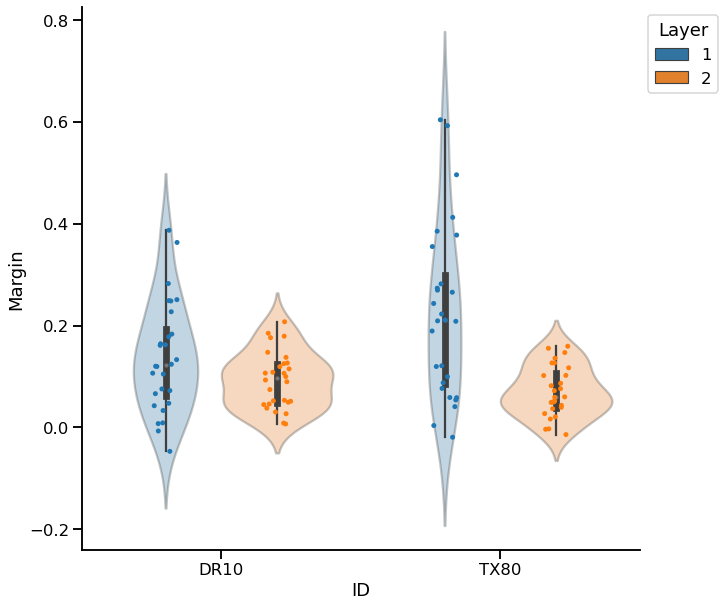

In [376]:
plt.figure(figsize=(10,10))
ax = sns.violinplot(x="ID",y="Margin",hue="Layer",data=summary_sessions.groupby(["ID","Category_Pair","Layer"]).mean().reset_index(), alpha = 0.2);
plt.setp(ax.collections, alpha=.3)
ax = sns.stripplot(x="ID",y="Margin",hue="Layer",data=summary_sessions.groupby(["ID","Category_Pair","Layer"]).mean().reset_index(),dodge=True);
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:2],labels[:2],title='Layer')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
sns.despine()

In [374]:
handles

In [201]:
Sessions[0].mean_margin_L1.shape

(28, 4)

# TODO: plot margin by layer and ID

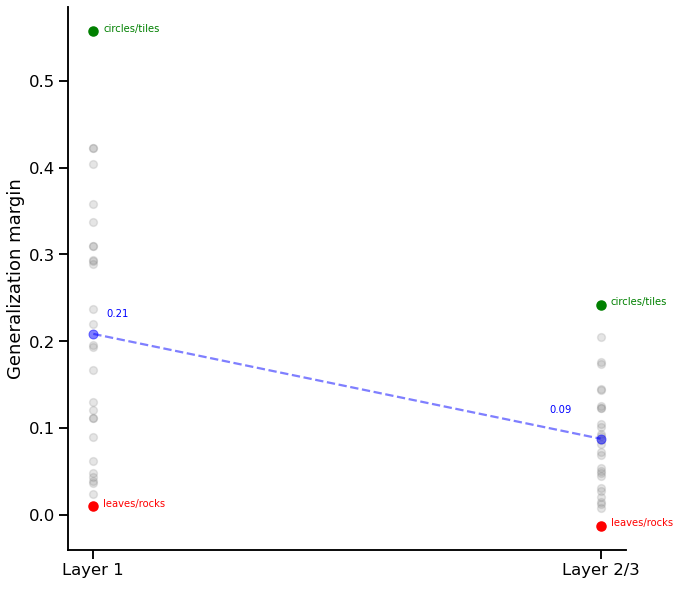

In [59]:
cat_pairs = utils.categorypairs_parser(cat_dict,pairs)
plt.figure(figsize=(10,10))
maxpair_L1 = mean_margin_L1.mean(1).argmax()
minpair_L1 = mean_margin_L1.mean(1).argmin()
maxpair_L2 = mean_margin_L2.mean(1).argmax()
minpair_L2 = mean_margin_L2.mean(1).argmin()
plt.scatter(np.zeros_like(mean_margin_L1.mean(1)),mean_margin_L1.mean(1),c="grey",s=60, alpha = 0.2)
plt.scatter(np.ones_like(mean_margin_L2.mean(1)),mean_margin_L2.mean(1),c="grey",s=60, alpha = 0.2)
point1 = [0, mean_margin_L1.mean()]
point2 = [1, mean_margin_L2.mean()]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'bo', linestyle="--", alpha = 0.5)
plt.text(point1[0]+0.025, point1[1]+0.02, str(np.round(mean_margin_L1.mean(),2)), color = "b")
plt.text(point2[0]-0.10, point2[1]+0.03, str(np.round(mean_margin_L2.mean(),2)), color = "b")
plt.scatter(0, mean_margin_L1.mean(1).max(),color="g")
plt.scatter(0, mean_margin_L1.mean(1).min(),color="r")
plt.text(0+.02, mean_margin_L1.mean(1).max(), cat_pairs[maxpair_L1], color = "g")
plt.text(0+.02, mean_margin_L1.mean(1).min(), cat_pairs[minpair_L1], color = "r")
plt.scatter(1, mean_margin_L2.mean(1).max(),color="g")
plt.scatter(1, mean_margin_L2.mean(1).min(),color="r")
plt.text(1+.02, mean_margin_L2.mean(1).max(), cat_pairs[maxpair_L2], color = "g")
plt.text(1+.02, mean_margin_L2.mean(1).min(), cat_pairs[minpair_L2], color = "r")
plt.ylabel("Generalization margin")
plt.xticks([0, 1],["Layer 1", "Layer 2/3"])
plt.xlabel(" ");
sns.despine()